The timings quoted in the COBRA paper were conducted on a single thread:

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1" 
os.environ["OPENBLAS_NUM_THREADS"] = "1" 
os.environ["MKL_NUM_THREADS"] = "1" # 
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

In [2]:
import numpy as np
import scipy
from scipy.stats import qmc

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from cobra.LCDM.LCDM import CobraLCDM
from cobra.GEN.GEN import CobraGEN
from cobra.Utils.no_wiggle_power import no_wiggle_power
from cobra.Utils.sigma_squared_bao import sigma_squared_bao
from cobra.Utils.ir_resummed_power import ir_resummed_power
from cobra.Utils.convert_units import convert_units_k_pk_from_hfid
from scipy.interpolate import CubicSpline

### Tests against CAMB

In the first part of this demonstration notebook, we'll be running COBRA predictions for the linear matter power spectrum and comparing to CAMB. (Our decomposition is based on CAMB 1.5.)

In [3]:
import camb 
from camb import model, initialpower 
from camb.dark_energy import DarkEnergyPPF, DarkEnergyFluid
from camb.reionization import TanhReionization 

The linear power spectrum can be computed either in LCDM or for more generalized model. Let's look at the former first; there are six parameters in this case.

In [4]:
## instantiate object of class

cobra_lcdm = CobraLCDM(param_range = 'def')

## specify wavenumbers and cosmology (these are interpreted in units of h_fid / Mpc where h_fid = 0.7, hence the notation)
k_min_hfid = 0.002
k_max_hfid = 1.5
n_bins = 300
k_out_hfid = np.logspace(np.log10(k_min_hfid), np.log10(k_max_hfid), n_bins)
cosmo = {'omch2':[0.13], 'ombh2':[0.021], 'ns':[0.97], 'As': [2], 'h': [0.68], 'z':[1]} # you pass a dict (more on vectorization below)

## by default, a call requires three arguments: the cosmological parameters, the output bins and the number of basis functions

## compute linear power spectrum with a different number of basis functions
plin_cobra_nb12 = cobra_lcdm.linear_matter_power(cosmo, k_out_hfid, n_basis_list = [12])[0] ## you get back an array of size #cosmo x #bins
plin_cobra_nb5 = cobra_lcdm.linear_matter_power(cosmo, k_out_hfid, n_basis_list = [5])[0]

cosmo_arr = np.array([val for val in cosmo.values()]).T

## let's compute the linear power spectrum using CAMB as well:
omega_c, omega_b, n_s, A_s, h, z = cosmo_arr[0]
A_s = A_s*10**(-9)
pars = camb.set_params(kmax = 4) 
pars.set_cosmology(H0=100*h, ombh2=omega_b, omch2=omega_c,mnu=0,TCMB=2.7255)
pars.InitPower.set_params(ns=n_s,As=A_s)
pars.set_accuracy(AccuracyBoost=3)
pars.set_matter_power(redshifts=[z], kmax=4.0,accurate_massive_neutrino_transfers=True)
results = camb.get_results(pars)

## note kh is in units of h/Mpc, not hfid/Mpc. 
kh, z, pk1 = results.get_matter_power_spectrum(minkh=k_min_hfid*0.7/h, maxkh=k_max_hfid*0.7/h, npoints = n_bins)
p_out_camb = pk1[0]*(0.7/h)**3


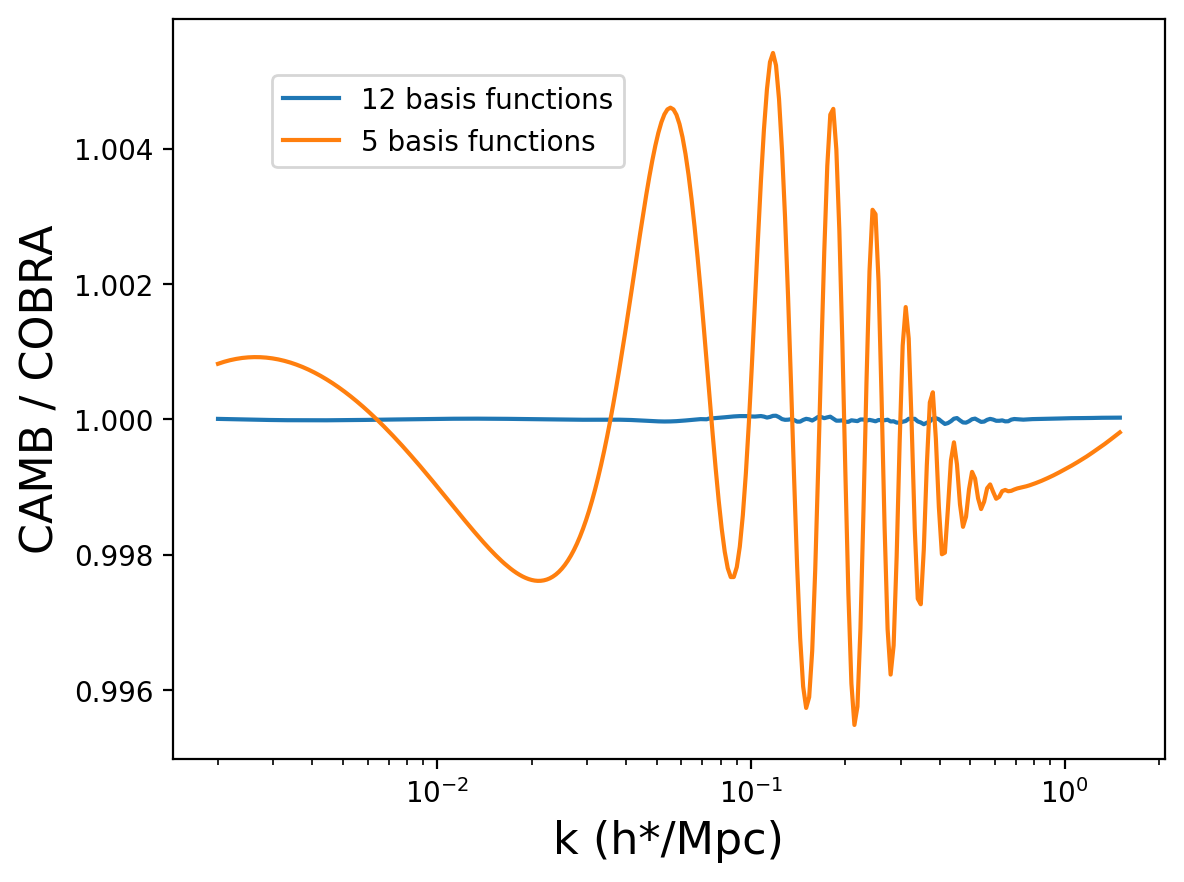

In [5]:
plt.xscale('log')
plt.plot(k_out_hfid, p_out_camb/plin_cobra_nb12)
plt.plot(k_out_hfid, p_out_camb/plin_cobra_nb5)
plt.xlabel('k (h*/Mpc)',fontsize=16)
plt.ylabel('CAMB / COBRA',fontsize=16)
plt.legend(['12 basis functions','5 basis functions'],loc=[0.1,0.8])
plt.show()

Evaluation is fast, even with maximum (default) number of basis functions:

In [6]:
%%timeit
plin_cobra = cobra_lcdm.linear_matter_power(cosmo, k_out_hfid, n_basis_list=[12])[0]

170 µs ± 262 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In more generalized cases, you can pass 10 cosmological parameters. They include massive neutrinos, dynamical dark energy and curvature. 

In [7]:
cobra_gen = CobraGEN(param_range = 'ext')

cosmo_gen = {'omch2':[0.12], 'ombh2':[0.023],'Omk':[0.15],'h':[0.75],'ns':[0.99],'Mnu':[0.5],'w0':[-0.9],'wp':[-0.6],'z':[1],'As':[4]} 
plin_cobra_gen_nb14 = cobra_gen.linear_matter_power(cosmo_gen, k_out_hfid, n_basis_list=[14])[0] ## use same k range as before
plin_cobra_gen_nb6 = cobra_gen.linear_matter_power(cosmo_gen, k_out_hfid, n_basis_list=[6])[0]


CAMB itself takes around half a minute to run for cosmologies with nonzero curvature:

In [8]:
cosmo_gen_array = np.array([val for val in cosmo_gen.values()]).T
omega_c,omega_b,omega_k,h,n_s,m_nu,w0,wp,z,A_s = cosmo_gen_array[0]
pars = camb.set_params(num_nu_massless = 2.044,kmax = 4.3464234,DoLensing=False)

pars.set_cosmology(H0=100*h, ombh2=omega_b, omch2=omega_c,mnu=m_nu,omk=omega_k,TCMB=2.7255)
pars.InitPower.set_params(ns=n_s,As=A_s*10**(-9))
pars.set_accuracy(AccuracyBoost=2)
pars.DarkEnergy=DarkEnergyPPF(w=w0, wa=wp-w0) ##plug in the correct value of wa = wp - w0
pars.set_matter_power(redshifts=[z], kmax=4.0,accurate_massive_neutrino_transfers=True)
results = camb.get_results(pars)
results.Params.Reion = TanhReionization(Reionization=True)
results = camb.get_results(pars)
kh, z, pk1 = results.get_matter_power_spectrum(k_min_hfid*0.7/h, maxkh=k_max_hfid*0.7/h, npoints = n_bins)
## note kh is in units of h/Mpc, not hfid/Mpc. 
p_out_camb_gen = pk1[0]*(0.7/h)**3

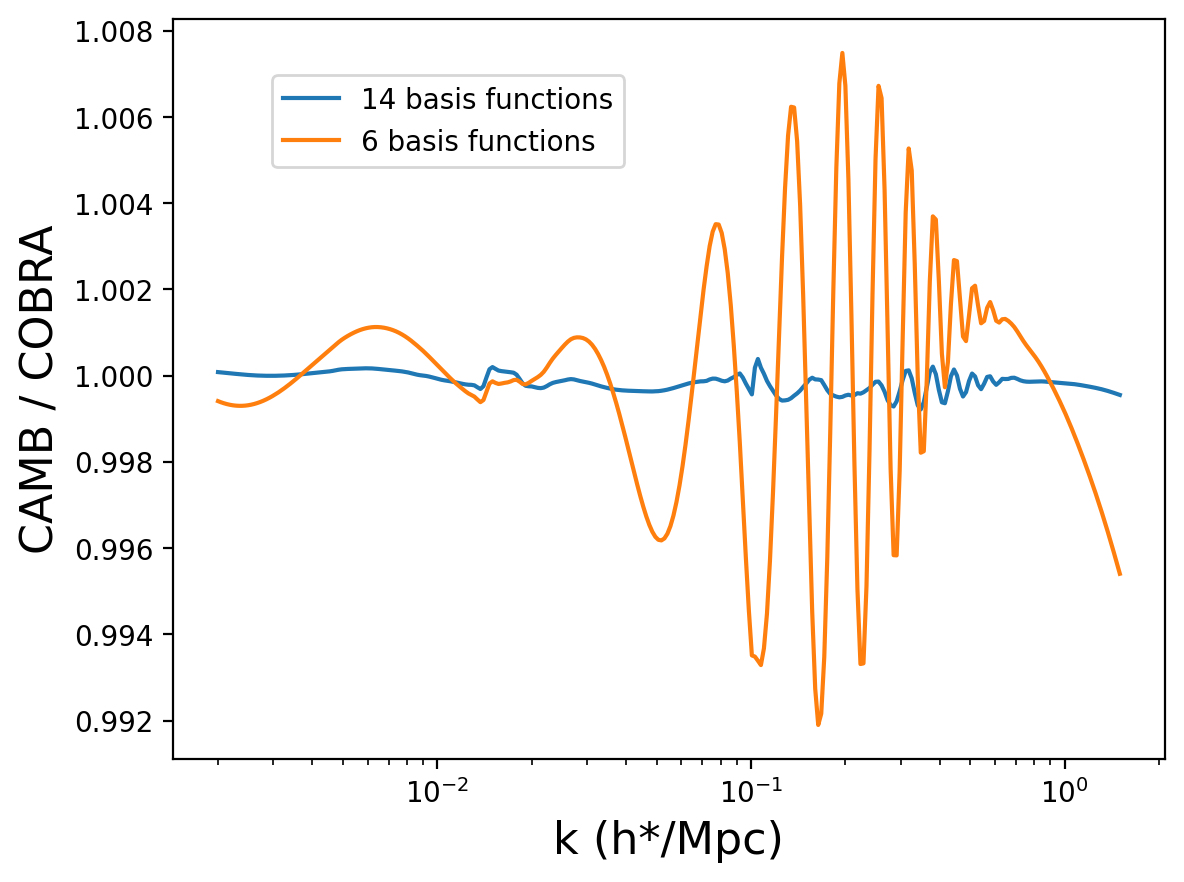

In [9]:
plt.xscale('log')
plt.plot(k_out_hfid, p_out_camb_gen/plin_cobra_gen_nb14)
plt.plot(k_out_hfid, p_out_camb_gen/plin_cobra_gen_nb6)
plt.xlabel('k (h*/Mpc)',fontsize=16)
plt.ylabel('CAMB / COBRA',fontsize=16)
plt.legend(['14 basis functions','6 basis functions'],loc=[0.1,0.8])
plt.show()

With COBRA, timings are much more favorable:

In [10]:
%%timeit
plin_cobra_gen = cobra_gen.linear_matter_power(cosmo_gen, k_out_hfid, n_basis_list = [14], resum = True, disps_hfid = np.array([30]))[0]


630 µs ± 8.1 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


You can also pass hundreds of cosmologies at once: let's do this for the default range of the extended parameter space
syntax is similar to BACCO here: see e.g. https://bacco.dipc.org/

In [11]:
l_bounds_tot = np.array([0.095,0.0202,-0.12,0.55,0.9,0,-1.25,-0.3,0.1,1]) ## parameter bounds for the default range
u_bounds_tot = np.array([0.145,0.0238,0.12,0.8,1.02,0.6,-0.75,0.3,3,5])

cobra_gen_def = CobraGEN(param_range = 'def')

In [12]:
%%timeit
ncos = 250
cosmo_unit_cube = np.random.uniform(0,1,(ncos,10))
cosmo_gen_array = qmc.scale(cosmo_unit_cube,l_bounds_tot,u_bounds_tot) 
cosmo_gen = {'omch2':cosmo_gen_array[:,0],
              'ombh2':cosmo_gen_array[:,1],
              'Omk':cosmo_gen_array[:,2],
              'h':cosmo_gen_array[:,3],
              'ns':cosmo_gen_array[:,4],
              'Mnu':cosmo_gen_array[:,5],
              'w0':cosmo_gen_array[:,6],
              'wa':cosmo_gen_array[:,7],
              'z':cosmo_gen_array[:,8],
              'As':cosmo_gen_array[:,9]} 
              
    
plin_cobra_gen = cobra_gen_def.linear_matter_power(cosmo_gen, k_out_hfid, n_basis_list = [12])[0]

27.2 ms ± 1.06 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Additional options for the Linear Power Spectrum

COBRA has some additional options for the linear power spectrum. For example, you can also request resummation via the wiggle-no-wiggle split. In LCDM, the displacement is emulated automatically (consistently with the wiggle-no-wiggle split). Let's look again at the LCDM instance we had above:

In [13]:
plin_cobra_noresum = cobra_lcdm.linear_matter_power(cosmo, k_out_hfid, n_basis_list = [12])[0] 
plin_cobra_resum = cobra_lcdm.linear_matter_power(cosmo, k_out_hfid, n_basis_list = [12], resum = True)[0] 

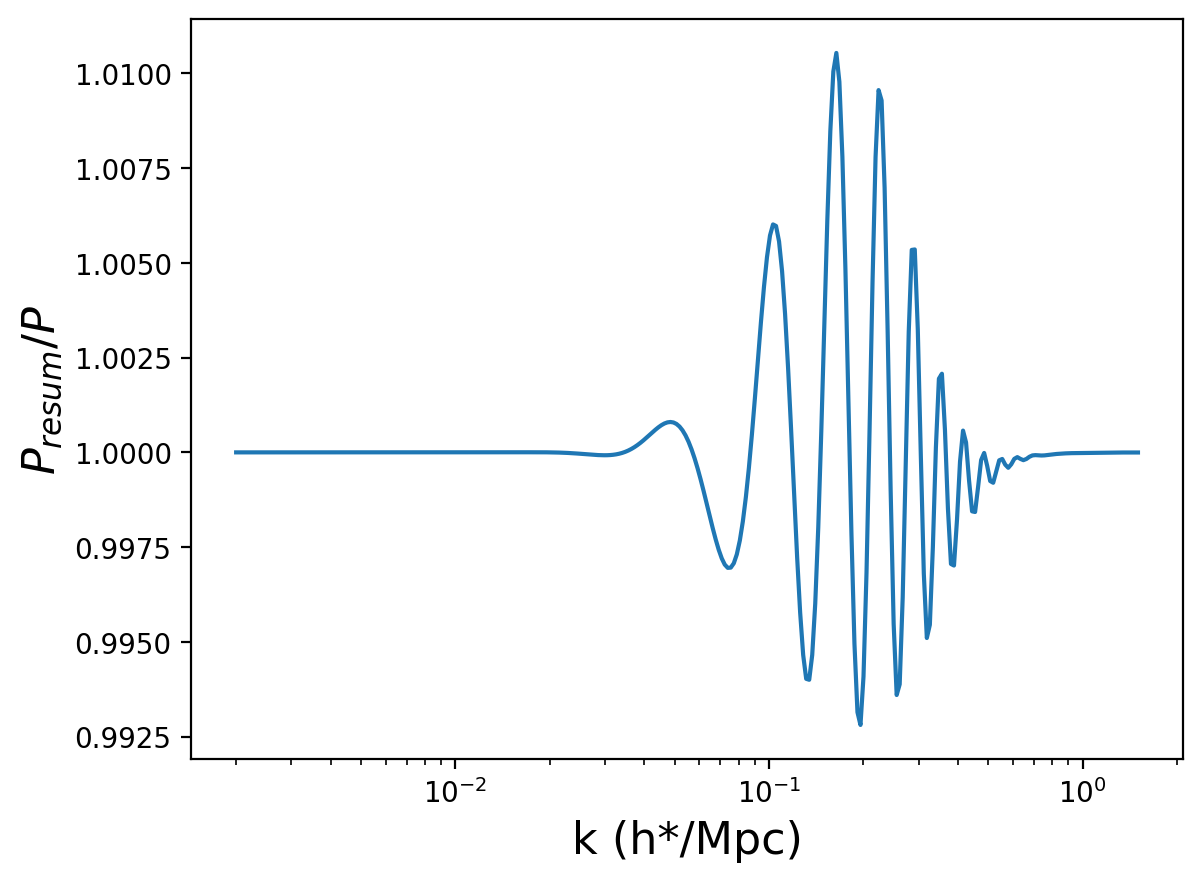

In [14]:
plt.xscale('log')
plt.plot(k_out_hfid, plin_cobra_resum/plin_cobra_noresum)
plt.xlabel('k (h*/Mpc)',fontsize=16)
plt.ylabel(r'$P_{resum} / P$',fontsize=16)
plt.show()

In extended cosmologies, the displacement is not emulated (yet) - you have to provide it yourself in the call. You can, however, compute the displacement beforehand yourself using the built-in brute-force integration via compute_disp. You can also directly apply compute_pir to a given input linear spectrum (though this is not vectorized)

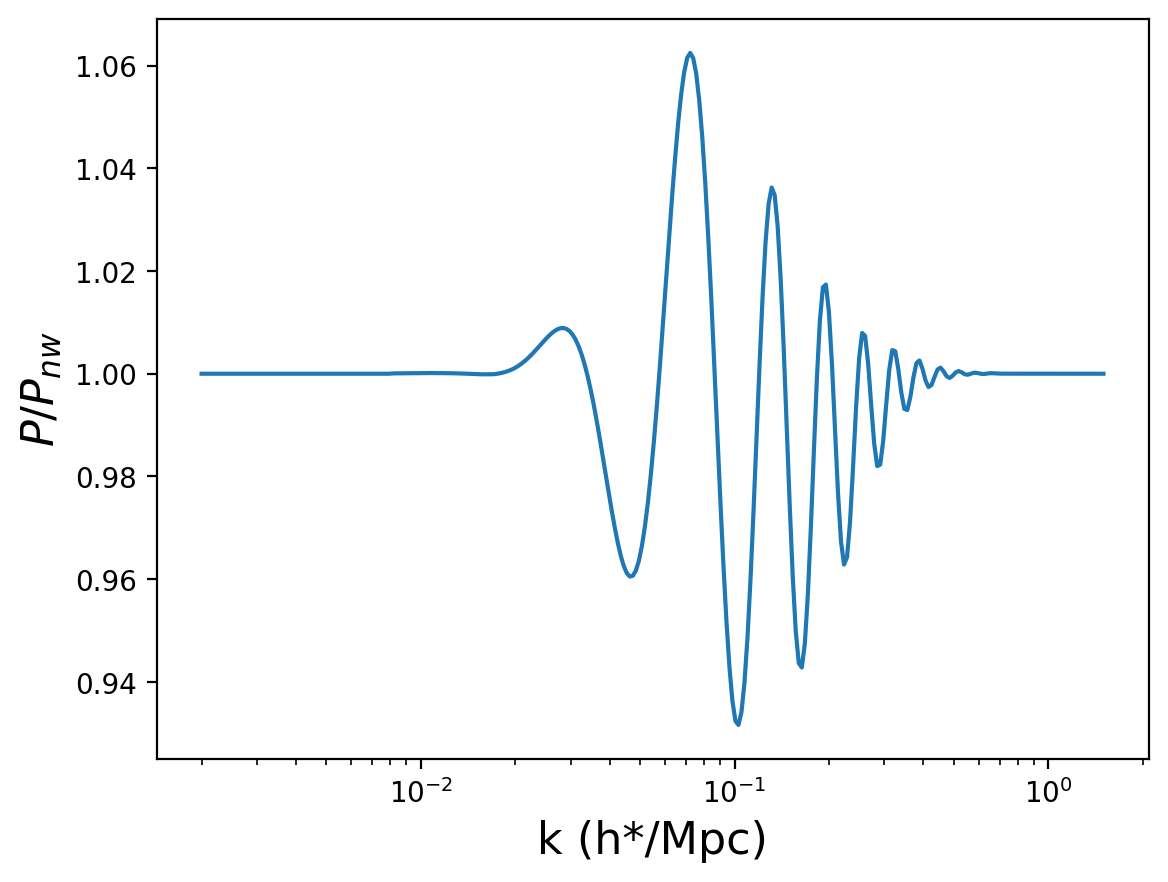

In [15]:
k_pk = np.array([k_out_hfid, plin_cobra_gen_nb14])
plin_gen_nw = no_wiggle_power(k_pk)[1]

plt.xscale('log')
plt.plot(k_out_hfid, plin_cobra_gen_nb14/plin_gen_nw)
plt.xlabel('k (h*/Mpc)',fontsize=16)
plt.ylabel(r'$P / P_{nw}$',fontsize=16)
plt.show()

It is still advisable to inspect the result of the no-wiggle calculation before using it for the more general cosmologies. You can also compute the displacement if you want: 

In [16]:
displ = sigma_squared_bao(k_pk)
displ

13.130697241129212

### Tests against velocileptors

In LCDM, we can also compute the power spectrum of galaxies as implemented in the EPT module of velocileptors. Let's see how that works! 
For the theory model and implementation of velocileptors we use here, see https://github.com/sfschen/velocileptors/blob/master/velocileptors/EPT/ept_fullresum_fftw.py and https://arxiv.org/pdf/2005.00523,  https://arxiv.org/abs/2012.04636. Note that we subtract the large-scale contributions from the loops, so that the one-loop prediction reduces to linear theory for small wavenumbers. If you want to run this test, you can manually download the relevant .dat files.

In [17]:
## some of these values taken from velocileptors demo notebook

bias_params_ept = {'b1':[1.68593608], 'b2':[-1.17], 'bs':[-0.715], 'b3':[-0.479], \
               'alpha0':[50], 'alpha2':[50], 'alpha4':[50], 'alpha6':[50], \
               'sn':[3000], 'sn2':[3000], 'sn4':[3000], 'bfog':[0]}

ept_cosmo = np.loadtxt("test_velocileptors_cosmo.dat") ## a test cosmology; note that A_s is fixed to 2e-9 as in the paper
ept_pell = np.loadtxt("test_velocileptors.dat") ## test example from velocileptors - monopole, quadrupole and hexadecapole
cosmo_ept = {'omch2':[ept_cosmo[0]], 'ombh2':[ept_cosmo[1]], 'ns':[ept_cosmo[2]], 
              'As': [ept_cosmo[3]], 'h': [ept_cosmo[4]], 'z':[ept_cosmo[5]]}

k_out_loop = cobra_lcdm.s_tables_loop["k_loop"] ## the test example from velocileptors is computed at k_loop wavenumbers

cosmo_ept

{'omch2': [0.13343717229883395],
 'ombh2': [0.02088306733337281],
 'ns': [0.9261770683452037],
 'As': [2.0],
 'h': [0.673728162358058],
 'z': [0.46735314471834877]}

In [18]:
%%timeit 
pell = cobra_lcdm.oneloop_galaxy_power_multipoles(cosmo_ept, bias_params_ept, k_out_loop, n_basis_list = [9,9]) 

1.88 ms ± 38.6 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [19]:
## the default number of basis functions for this parameter range is 12
cobra_pell_nb12 = cobra_lcdm.oneloop_galaxy_power_multipoles(cosmo_ept, bias_params_ept, k_out_loop, n_basis_list = [12,12])[0]

## for comparison, use 6 for linear and 6 for loop calculation
cobra_pell_nb6 = cobra_lcdm.oneloop_galaxy_power_multipoles(cosmo_ept, bias_params_ept, k_out_loop, n_basis_list = [6,6])[0] 

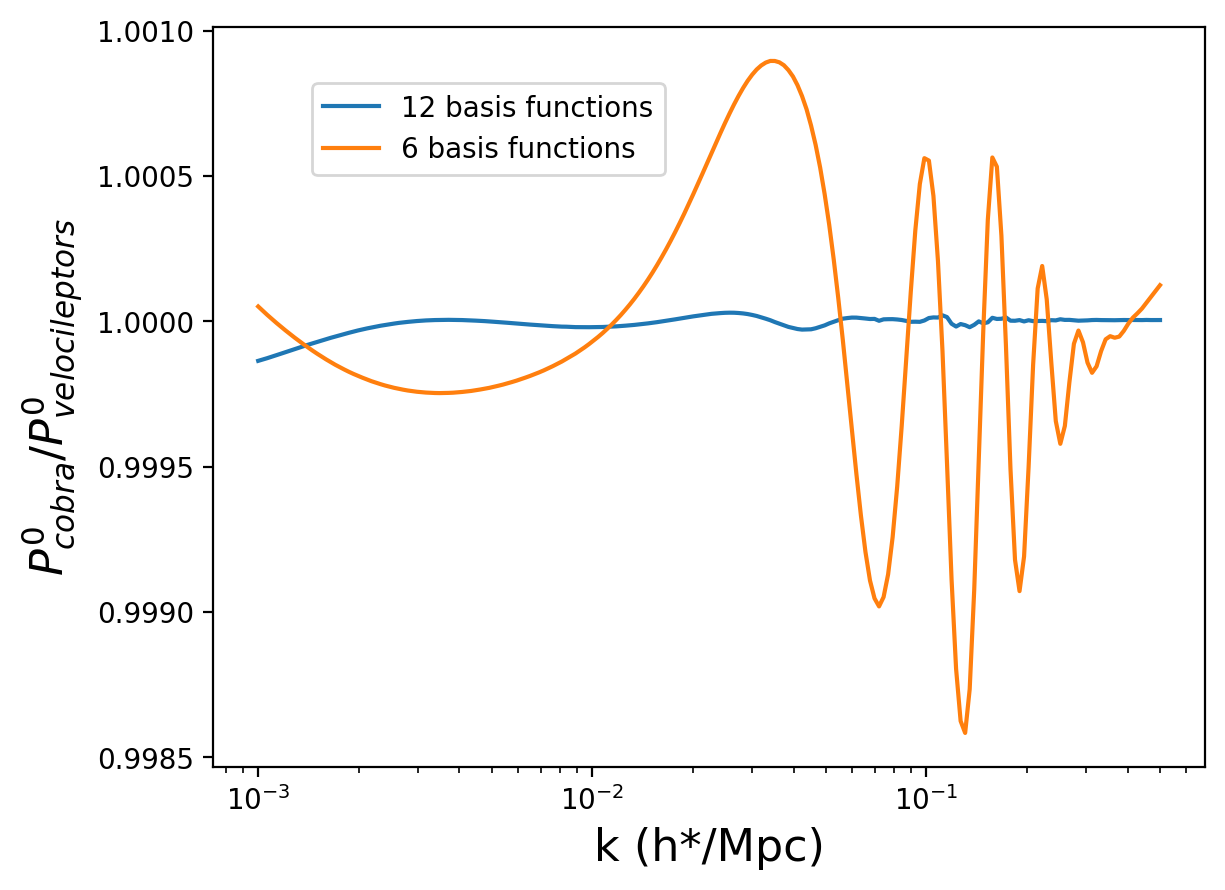

In [20]:
## let's look at the monopole: 
plt.xscale('log')
plt.plot(k_out_loop, cobra_pell_nb12[0]/ept_pell[0])
plt.plot(k_out_loop, cobra_pell_nb6[0]/ept_pell[0])
plt.xlabel('k (h*/Mpc)',fontsize=16)
plt.ylabel(r'$P^0_{cobra} / P^0_{velocileptors}$',fontsize=16)
plt.legend(['12 basis functions','6 basis functions'],loc=[0.1,0.8])
plt.show()

You can also convert power spectra back to h/Mpc units:


In [21]:
k_p0 = np.array([k_out_loop, cobra_pell_nb12[0]])
k_p0_h = convert_units_k_pk_from_hfid(k_p0, h_out = ept_cosmo[4])

Vectorization is also supported for the velocileptors calculation:

In [22]:
ncos = 250
bias_params_ept_vect = {'b1':[1.68593608]*ncos, 'b2':[-1.17]*ncos, 'bs':[-0.715]*ncos, 'b3':[-0.479]*ncos, \
               'alpha0':[50]*ncos, 'alpha2':[50]*ncos, 'alpha4':[50]*ncos, 'alpha6':[50]*ncos, \
               'sn':[3000]*ncos, 'sn2':[3000]*ncos, 'sn4':[3000]*ncos, 'bfog':[0]*ncos}
cosmo_ept_vect = {'omch2':[ept_cosmo[0]]*ncos, 'ombh2':[ept_cosmo[1]]*ncos, 'ns':[ept_cosmo[2]]*ncos, 
              'As': [ept_cosmo[3]]*ncos, 'h': [ept_cosmo[4]]*ncos, 'z':[ept_cosmo[5]]*ncos}

In [29]:
%%timeit
pell = cobra_lcdm.oneloop_galaxy_power_multipoles(cosmo_ept_vect, bias_params_ept_vect, k_out_loop, n_basis_list = [6,6]) 

68.9 ms ± 715 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
